# Citibike Modeling: Incorporate Exogenous Variables

This script will incorporate the NYC recovery index in an attempt to appropriately control for the COVID-19 pandemic's effect on ridership.

In [22]:
# Standard imports

import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import geopandas as gpd
from scipy.fft import fft, fftfreq, fftshift
import scipy
import itertools
from ast import literal_eval

# Set style
plt.style.use('seaborn')

In [2]:
# Import util file

from util import dickey_fuller, process_neighborhood, report_metrics, plot_results

In [3]:
# Modeling

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.graphics.tsaplots as tsa

from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose

from sklearn import metrics

#### Ridership Data Import and Prep

In [4]:
# Import clean dataset

df_citibike = pd.read_csv('./../clean_data/final_clean_ridership.csv', low_memory=False)

In [5]:
# Convert starttime to date and set as index

df_citibike['starttime'] = pd.to_datetime(df_citibike['starttime'])

df_citibike.set_index('starttime', inplace=True)

In [6]:
# Create the daily file

daily_ridership = df_citibike[['ride_count']].resample('1D').sum()

# Backfill dates with 0 rides (logic for this change in EDA notebook)
daily_ridership['ride_count'] = daily_ridership['ride_count'].replace(to_replace=0, method='bfill')

In [7]:
# Define Train / Test split time

test_start = '2020-11-01'

In [8]:
# Resample to weekly

weekly_ridership = daily_ridership.resample('W-SUN').sum()

# Log transform ridership
weekly_ridership['ride_count_log'] = weekly_ridership['ride_count'].apply(lambda x: np.log(x))

In [9]:
# Create future time stamp

weekly_ridership['future'] = (weekly_ridership.index >= test_start).astype('int')

#### COVID data import and prep

- The COVID recovery index has metrics for NYC's recovery across six categories
- The data only begins in 2020 through November 2021 so dates have been backfilled with the starting value (essentially assuming prior to 2020, the index is 100). While this definitely isn't true, I don't have a great way to infer categories prior to this date

In [94]:
# Read in the COVID data

covid_df = pd.read_csv('./../covid_data/data-uIenF.csv')

In [95]:
# Convert the axis to datetime and create a "overall_index" column

covid_df['Date'] = pd.to_datetime(covid_df['Date'])

covid_df.set_index('Date', inplace=True)

covid_df['overall_index'] = covid_df.sum(axis=1)

In [96]:
covid_df.head()

,Covid-19 Hospitalizations Index,Unemployment Claims Index,Home Sales Index,Rental Inventory Index,Subway Mobility Index,Restaurant Reservations Index,overall_index
Date,,,,,,,
2020-01-04,16.7,16.8,14.6,16.1,15.8,16.7,96.7
2020-01-11,16.7,15.5,19.4,16.1,16.9,16.7,101.3
2020-01-18,16.7,15.5,19.0,16.2,16.7,16.7,100.8
2020-01-25,16.7,16.2,17.9,16.6,17.3,16.7,101.4
2020-02-01,16.7,18.4,18.2,16.3,17.2,16.7,103.5


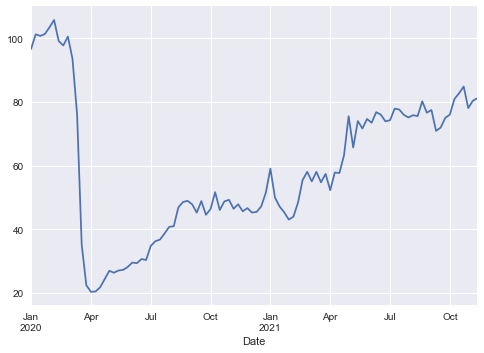

In [97]:
# Plot the overall index

covid_df['overall_index'].plot();

In [98]:
# Shift the date axis of the covid_df by one day to match sequence of the ridership data

date_list = []
start_date = datetime.strptime('2020-01-05', "%Y-%m-%d")
time_delta = timedelta(days=7)

for i in range(98):
    if i == 0:
        date = start_date
        date_list.append(start_date)
    else:
        date += time_delta
        date_list.append(date)
        
covid_df['Date'] = date_list

covid_df.set_index('Date', drop=True, inplace=True)

In [99]:
# Merge the covid data to the weekly ridership

weekly_ridership = weekly_ridership.merge(covid_df, how='left', left_index=True, right_index=True)

In [100]:
# Backfill the values for pre-COVID dates

columns = ['Covid-19 Hospitalizations Index', 'Unemployment Claims Index', 'Home Sales Index',
           'Rental Inventory Index', 'Subway Mobility Index', 'Restaurant Reservations Index', 'overall_index']

weekly_ridership[columns] = weekly_ridership[columns].replace(to_replace=np.nan, method='bfill')

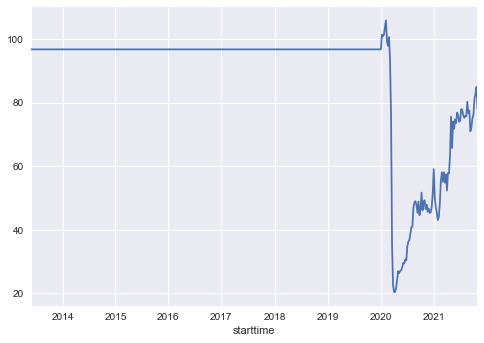

In [107]:
weekly_ridership['overall_index'].plot();

## Modeling

- Iterations are as follows:
    - Log transformed or regular ridership
    - Various permutations of the recovery index: overall then test various combinations of the subcategories

In [108]:
weekly_ridership.head(1)

,ride_count,ride_count_log,future,Covid-19 Hospitalizations Index,Unemployment Claims Index,Home Sales Index,Rental Inventory Index,Subway Mobility Index,Restaurant Reservations Index,overall_index
starttime,,,,,,,,,,
2013-06-02,24693,10.114275,0,16.7,16.8,14.6,16.1,15.8,16.7,96.7


In [126]:
# Create future time stamp

weekly_ridership['future'] = (weekly_ridership.index >= test_start).astype('int')

# Create train test splits

train_weekly = weekly_ridership[(weekly_ridership['future'] == 0)] #& (weekly_ridership.index > '2016-12-31')]
test_weekly = weekly_ridership[weekly_ridership['future'] == 1]

In [173]:
# First sarimax model with overall index

sarimax_overall = SARIMAX(train_weekly['ride_count'], exog=train_weekly['overall_index'],
                       order=(1, 1, 1), seasonal_order=(0, 1, 1, 52)).fit(disp=False)

Explained Variance: 0.8946
MAE: 96,056.7043
RMSE: 113,905.7172
r^2: 0.7228


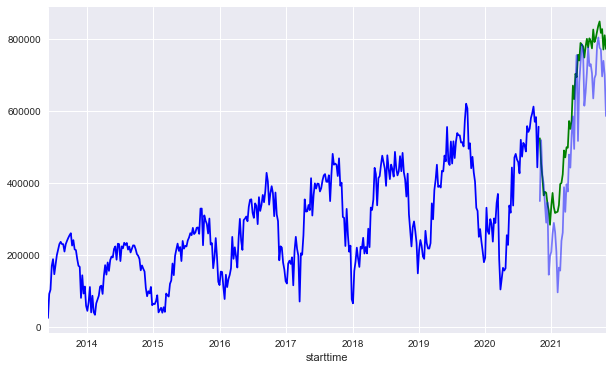

In [185]:
# Create dataframe to store results

weekly_future_df = weekly_ridership.loc[weekly_ridership.future == 1].copy()

weekly_future_df['sari_overall'] = sarimax_overall.forecast(steps = len(test_weekly), 
                                                            exog=test_weekly['overall_index'])

plot_results(weekly_ridership, weekly_future_df['sari_overall'], False)

results = report_metrics(test_weekly['ride_count'], weekly_future_df['sari_overall'], True)

In [181]:
#Subway mobility

sarimax_subway = SARIMAX(train_weekly['ride_count'], exog=train_weekly['Subway Mobility Index'],
                       order=(1, 1, 1), seasonal_order=(0, 1, 1, 52)).fit(disp=False)

Explained Variance: 0.9016
MAE: 97,036.9353
RMSE: 113,485.8480
r^2: 0.7248


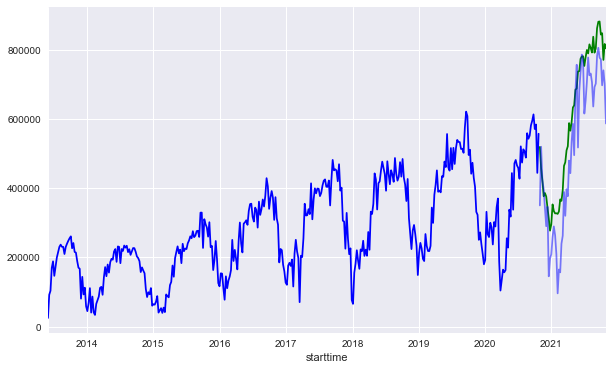

In [189]:
weekly_future_df['sari_subway'] = sarimax_subway.forecast(steps = len(test_weekly), 
                                                            exog=test_weekly['Subway Mobility Index'])

plot_results(weekly_ridership, weekly_future_df['sari_subway'], False)

results = report_metrics(test_weekly['ride_count'], weekly_future_df['sari_subway'], True)

In [195]:
# Restaurant reservations

sarimax_rest = SARIMAX(train_weekly['ride_count'], exog=train_weekly['Restaurant Reservations Index'],
                       order=(1, 1, 1), seasonal_order=(0, 1, 1, 52)).fit(disp=False)

Explained Variance: 0.8999
MAE: 72,481.5759
RMSE: 90,473.8318
r^2: 0.8251


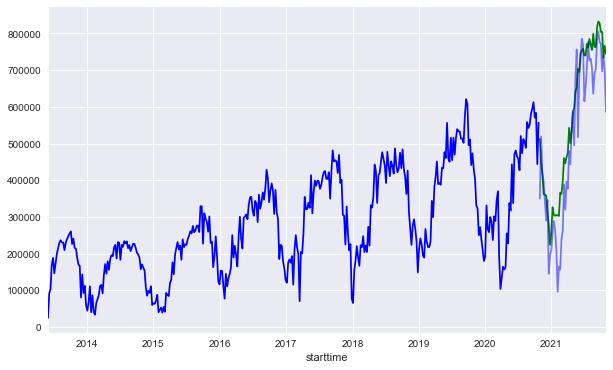

In [196]:
weekly_future_df['sari_restaurant'] = sarimax_rest.forecast(steps = len(test_weekly), 
                                                            exog=test_weekly['Restaurant Reservations Index'])

plot_results(weekly_ridership, weekly_future_df['sari_restaurant'], False)

results = report_metrics(test_weekly['ride_count'], weekly_future_df['sari_restaurant'], True)

In [198]:
# Hospitalizations

sarimax_hosp = SARIMAX(train_weekly['ride_count'], exog=train_weekly['Covid-19 Hospitalizations Index'],
                       order=(1, 1, 1), seasonal_order=(0, 1, 1, 52)).fit(disp=False)

Explained Variance: 0.8577
MAE: 68,460.2204
RMSE: 83,623.7416
r^2: 0.8506


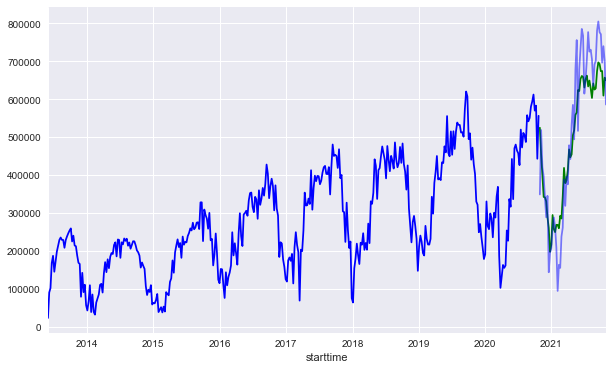

In [199]:
weekly_future_df['sari_hospital'] = sarimax_hosp.forecast(steps = len(test_weekly), 
                                                            exog=test_weekly['Covid-19 Hospitalizations Index'])

plot_results(weekly_ridership, weekly_future_df['sari_hospital'], False)

results = report_metrics(test_weekly['ride_count'], weekly_future_df['sari_hospital'], True)

### Log Transformed Data

In [193]:
# First sarimax model with overall index

sarimax_overall_log = SARIMAX(train_weekly['ride_count_log'], exog=np.log(train_weekly['overall_index']),
                            order=(1, 1, 1), seasonal_order=(0, 1, 1, 52)).fit(disp=False)

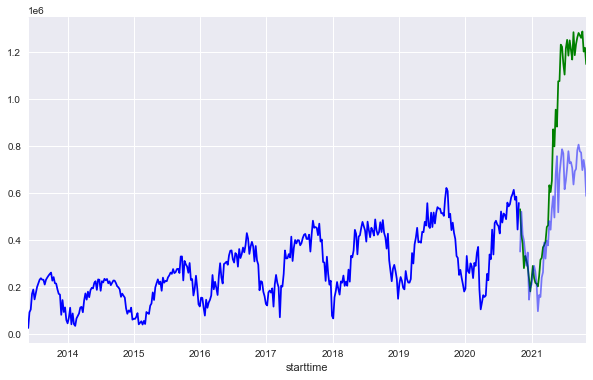

In [194]:
weekly_future_df['sari_overall_log'] = sarimax_overall_log.forecast(steps = len(test_weekly), 
                                                                    exog=np.log(test_weekly['overall_index']))

plot_results(weekly_ridership, weekly_future_df['sari_overall_log'], True)

### Conclusions: 

- Log transformed data performs quite poorly with exogenous variables included, resulting in an incredibly aggressive forecast. I will not log transform the data going forward
- Most "intuitive" COVID factors, including subway mobility, restaurant reservations, and hospitalizations perform similarly. Will check for collinearity among some of these and then decide which combinations to try.

In [203]:
train_weekly.drop(['future', 'ride_count', 'ride_count_log'], axis=1).corr()

,Covid-19 Hospitalizations Index,Unemployment Claims Index,Home Sales Index,Rental Inventory Index,Subway Mobility Index,Restaurant Reservations Index,overall_index
Covid-19 Hospitalizations Index,1.000000,0.956338,0.513345,0.719344,0.964151,0.965908,0.974448
Unemployment Claims Index,0.956338,1.000000,0.398501,0.851179,0.993598,0.993840,0.989629
Home Sales Index,0.513345,0.398501,1.000000,-0.079579,0.465811,0.444611,0.511460
Rental Inventory Index,0.719344,0.851179,-0.079579,1.000000,0.817760,0.827980,0.789892
Subway Mobility Index,0.964151,0.993598,0.465811,0.817760,1.000000,0.996939,0.997008
Restaurant Reservations Index,0.965908,0.993840,0.444611,0.827980,0.996939,1.000000,0.995690
overall_index,0.974448,0.989629,0.511460,0.789892,0.997008,0.995690,1.000000


Subway mobility and restaurant reservations are almost perfectly combined. The combination that I will try is to add the hospitalization index with subway mobility and restaurant reservations.

In [386]:
# Combine hospitalization index, subway mobility, and restaurant reservations

train_weekly['hosp_subway_rest'] = train_weekly['Covid-19 Hospitalizations Index'] + \
                                   train_weekly['Subway Mobility Index'] + \
                                   train_weekly['Restaurant Reservations Index']

test_weekly['hosp_subway_rest'] = test_weekly['Covid-19 Hospitalizations Index'] + \
                                  test_weekly['Subway Mobility Index'] + \
                                  test_weekly['Restaurant Reservations Index']

weekly_ridership['hosp_subway_rest'] = weekly_ridership['Covid-19 Hospitalizations Index'] + \
                                       weekly_ridership['Subway Mobility Index'] + \
                                       weekly_ridership['Restaurant Reservations Index']

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_97387/316489103.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_weekly['hosp_subway_rest'] = train_weekly['Covid-19 Hospitalizations Index'] + \
/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_97387/316489103.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_weekly['hosp_subway_rest'] = test_weekly['Covid-19 Hospitalizations Index'] + \


In [208]:
sarimax_combined = SARIMAX(train_weekly['ride_count'], exog=train_weekly['hosp_subway_rest'],
                       order=(1, 1, 1), seasonal_order=(0, 1, 1, 52)).fit(disp=False)

Explained Variance: 0.9058
MAE: 68,743.9348
RMSE: 86,407.5581
r^2: 0.8405


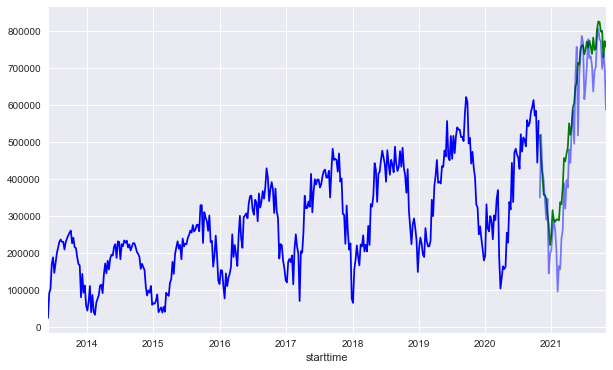

In [210]:
weekly_future_df['sari_combined'] = sarimax_combined.forecast(steps = len(test_weekly), 
                                                              exog=test_weekly['hosp_subway_rest'])

plot_results(weekly_ridership, weekly_future_df['sari_combined'], False)

results = report_metrics(test_weekly['ride_count'], weekly_future_df['sari_combined'], True)

### Conclusions

The combination of hospitalizations, subway ridership, and restaurant reservations seems to perform the best. Will perform a grid search to ensure that we have the optimal order and seasonal order.

In [212]:
# Create tuples of every p, d, q combination for 0 and 1

p = q = range(0, 2)
pdq = list(itertools.product(p, [1], q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, [1], q))]

# Set initial EV to some initially low amount
best_ev = 0

for param in pdq:
    for param_seasonal in seasonal_pdq: 
        mod = SARIMAX(train_weekly['ride_count'], exog=train_weekly['hosp_subway_rest'], 
                      order=param, seasonal_order=param_seasonal).fit(maxiter=1000, disp=False)
        
        forecast = mod.forecast(steps = len(test_weekly), exog=test_weekly['hosp_subway_rest'])
        
        ev = metrics.explained_variance_score(test_weekly['ride_count'], forecast)

        if ev > best_ev:
            best_ev = ev
            best_order = param
            best_s_order = param_seasonal

In [214]:
print(ev, best_order, best_s_order)

0.9047864856387664 (1, 1, 1) (0, 1, 1, 52)


In [387]:
# Retrain model on full dataset

final_sarimax = SARIMAX(weekly_ridership['ride_count'], exog=weekly_ridership['hosp_subway_rest'], 
                        order=(1, 1, 1), seasonal_order=(0, 1, 1, 52)).fit(maxiter=1000, disp=False)

The optimal ordering is the model that I've already run!

## Generate a 2022 forecast and scenario analysis

- Will create a range of forecasts based on certain COVID-19 scenarios
    - Scenario 1: index recovers in linear fashion back up to starting point
    - Scenario 2: index is held flat to current
    - Scenario 3: index gets half as bad for two months to start the year then recovers slowly
    - Scenario 4: index gets to March 2020 levels for a couple months then begins to recover

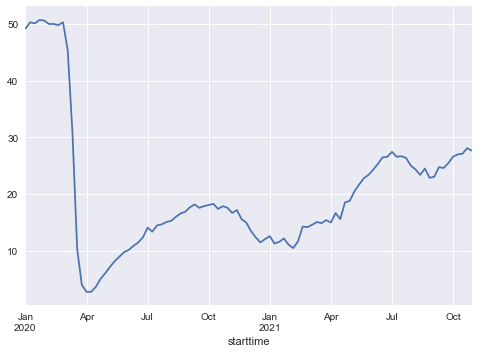

In [388]:
weekly_ridership[weekly_ridership.index > '2019-12-31']['hosp_subway_rest'].plot();

In [389]:
# From the below, we can see that the index bottom out on 4/5 at 2.8

weekly_ridership[(weekly_ridership.index > '2020-03-22') & (weekly_ridership.index < '2020-04-26')]

,ride_count,ride_count_log,future,Covid-19 Hospitalizations Index,Unemployment Claims Index,Home Sales Index,Rental Inventory Index,Subway Mobility Index,Restaurant Reservations Index,overall_index,hosp_subway_rest
starttime,,,,,,,,,,,
2020-03-29,103945,11.551617,0,1.9,0.6,4.8,13.1,2.1,0.0,22.5,4.0
2020-04-05,135343,11.815568,0,1.3,0.6,3.8,13.2,1.5,0.0,20.4,2.8
2020-04-12,164224,12.008987,0,1.5,0.5,4.0,13.2,1.3,0.0,20.5,2.8
2020-04-19,156689,11.962018,0,2.4,0.9,3.5,13.7,1.3,0.0,21.8,3.7


In [390]:
# The "normalized" version of the index seemed to top out at around 50.

weekly_ridership[(weekly_ridership.index > '2019-12-31') & (weekly_ridership.index < '2020-03-01')]

,ride_count,ride_count_log,future,Covid-19 Hospitalizations Index,Unemployment Claims Index,Home Sales Index,Rental Inventory Index,Subway Mobility Index,Restaurant Reservations Index,overall_index,hosp_subway_rest
starttime,,,,,,,,,,,
2020-01-05,192216,12.166375,0,16.7,16.8,14.6,16.1,15.8,16.7,96.7,49.2
2020-01-12,331476,12.711311,0,16.7,15.5,19.4,16.1,16.9,16.7,101.3,50.3
2020-01-19,266438,12.492897,0,16.7,15.5,19.0,16.2,16.7,16.7,100.8,50.1
2020-01-26,258491,12.462616,0,16.7,16.2,17.9,16.6,17.3,16.7,101.4,50.7
2020-02-02,299758,12.610731,0,16.7,18.4,18.2,16.3,17.2,16.7,103.5,50.6
2020-02-09,286761,12.566404,0,16.7,19.3,19.9,16.6,16.6,16.7,105.8,50.0
2020-02-16,237065,12.376090,0,16.7,15.8,17.1,16.3,16.6,16.7,99.2,50.0
2020-02-23,301722,12.617261,0,16.7,16.6,15.4,16.0,16.4,16.7,97.8,49.8


In [391]:
start_date2 = datetime.strptime('2020-11-01', "%Y-%m-%d")
time_delta2 = timedelta(days=7)

In [392]:
date_list2 = []

for i in range(113):
    if i == 0:
        date2 = start_date2
        date_list2.append(start_date2)
    else:
        date2 += time_delta
        date_list2.append(date2)
        
df_covid_scenarios = pd.DataFrame(index=date_list2, columns=['lin_recovery', 'flat', 'mild_lockdown',
                                                             'full_lockdown'])

In [393]:
# Merge the actuals into the dataframe

df_covid_scenarios = df_covid_scenarios.merge(weekly_ridership[['hosp_subway_rest']], left_index=True, right_index=True, how='left')

In [394]:
# Set the scenarios equal to actuals for as long as we have the data

df_covid_scenarios['lin_recovery'] = df_covid_scenarios['hosp_subway_rest']
df_covid_scenarios['flat'] = df_covid_scenarios['hosp_subway_rest']
df_covid_scenarios['mild_lockdown'] = df_covid_scenarios['hosp_subway_rest']
df_covid_scenarios['full_lockdown'] = df_covid_scenarios['hosp_subway_rest']

In [395]:
# There are 113 steps that need to happen through the end of 2022

steps = df_covid_scenarios[df_covid_scenarios['lin_recovery'].isna()].shape[0]

steps

60

In [396]:
# Define list of actual values

actuals = list(df_covid_scenarios.dropna(axis=0)['hosp_subway_rest'])

In [397]:
# Define the launch point: what is the last actual value that we have

final_actual = df_covid_scenarios.dropna(axis=0).tail().iloc[-1,0]

In [398]:
# Scenario 1: linear recovery

linear_recovery = actuals + list(np.linspace(start=final_actual, stop=50, num=steps))

In [399]:
# Scenario 2: held flat to most recent

flat_recovery = actuals + ([final_actual] * steps)

In [400]:
# Scenario 3: mild lockdown

remainder_2021 = df_covid_scenarios[(df_covid_scenarios.index > '2021-10-31') & (df_covid_scenarios.index < '2022-01-01')].shape[0]

# First step is linear recovery through end of 2021
step1 = list(np.linspace(start=final_actual, stop=50, num=113))[0:8]

# Step 2 is shock down to 15
step2 = [15] * 8

# Step 3 is recovery to 25 through year end
step3 = list(np.linspace(start=15, stop=25, num=(steps - (len(step1 + step2)))))

mild_lockdown = actuals + step1 + step2 + step3

In [401]:
# Scenario 4: full lockdown

# remainder_2021

step1 = list(np.linspace(start=final_actual, stop=50, num=113))[0:8]

# Step 2 is shock down to 3 for three months
step2 = [3] * 8

# Step 3 is recovery to 20 through year end
step3 = list(np.linspace(start=3, stop=20, num=(steps - (len(step1 + step2)))))

full_lockdown = actuals + step1 + step2 + step3

In [402]:
# Add final scenarios to dataframe

df_covid_scenarios['lin_recovery'] = linear_recovery
df_covid_scenarios['flat'] = flat_recovery
df_covid_scenarios['mild_lockdown'] = mild_lockdown
df_covid_scenarios['full_lockdown'] = full_lockdown

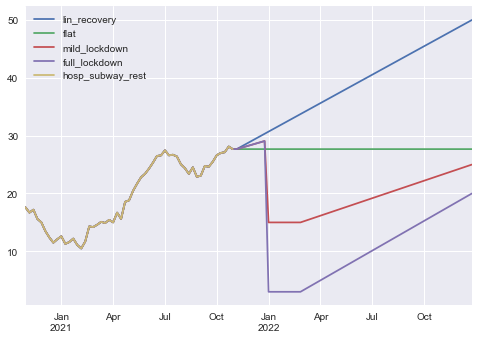

In [403]:
df_covid_scenarios.plot();

In [407]:
df_covid_scenarios[df_covid_scenarios.index > '10/31/2021']['lin_recovery']

(60, 5)

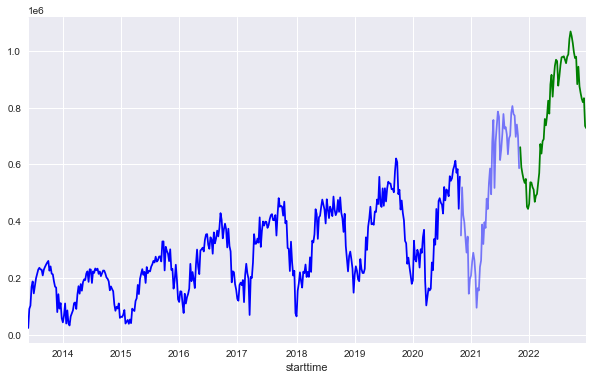

In [408]:
# Linear recovery forecast

forecast_lin_recovery = final_sarimax.forecast(steps = 60,
                                               exog=df_covid_scenarios[df_covid_scenarios.index > '10/31/2021']['lin_recovery'])

plot_results(weekly_ridership, forecast_lin_recovery, False)

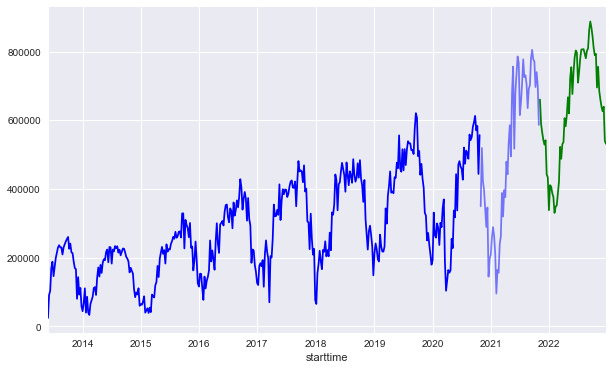

In [410]:
# Mild lockdown

forecast_mild = final_sarimax.forecast(steps = 60,
                                       exog=df_covid_scenarios[df_covid_scenarios.index > '10/31/2021']['mild_lockdown'])

plot_results(weekly_ridership, forecast_mild, False)

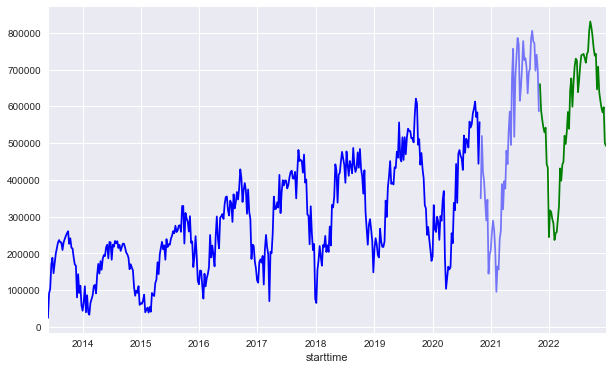

In [413]:
# Severe lockdown

forecast_severe = final_sarimax.forecast(steps = 60,
                                         exog=df_covid_scenarios[df_covid_scenarios.index > '10/31/2021']['full_lockdown'])

plot_results(weekly_ridership, forecast_severe, False)

In [414]:
overall_preds = pd.DataFrame(index=final_sarimax.forecast(steps= 60,
                                                          exog=df_covid_scenarios[df_covid_scenarios.index > '10/31/2021']['full_lockdown']).index,
                                                          columns=['preds'])

overall_preds['preds'] = final_sarimax.forecast(steps= 60, 
                                                exog=df_covid_scenarios[df_covid_scenarios.index > '10/31/2021']['full_lockdown'])

overall_2022 = overall_preds[overall_preds.index > '12/31/2021']['preds'].sum()

print(f"In 2022, there are forecast to be {overall_2022:,.0f} rides")

In 2022, there are forecast to be 29,998,747 rides


In [415]:
forecast_severe.loc[(forecast_severe.index > '2022-05-31') & (forecast_severe.index < '2022-10-01')].sum()

12458905.598821865

In [416]:
forecast_severe

2021-11-07    660489.502285
2021-11-14    589067.049722
2021-11-21    564266.116131
2021-11-28    543257.690454
2021-12-05    529265.420594
2021-12-12    541982.533510
2021-12-19    442698.333977
2021-12-26    433645.996860
2022-01-02    244540.512124
2022-01-09    317211.514759
2022-01-16    313159.345144
2022-01-23    293962.939818
2022-01-30    282489.488768
2022-02-06    236508.590346
2022-02-13    255004.469713
2022-02-20    258303.450724
2022-02-27    292941.201396
2022-03-06    329264.341824
2022-03-13    431315.575277
2022-03-20    397717.770891
2022-03-27    441383.340400
2022-04-03    448930.433578
2022-04-10    519985.329719
2022-04-17    497594.986848
2022-04-24    531601.009651
2022-05-01    584677.289724
2022-05-08    539097.898184
2022-05-15    642359.568393
2022-05-22    675901.313072
2022-05-29    599084.469765
2022-06-05    663201.903176
2022-06-12    707910.865164
2022-06-19    729515.063277
2022-06-26    724659.733493
2022-07-03    638575.149796
2022-07-10    671295

In [418]:
# Export results to Excel

forecast_severe.to_csv('./../covid_results/forecast_severe.csv')
forecast_mild.to_csv('./../covid_results/forecast_mild.csv')
df_covid_scenarios.to_csv('./../covid_results/covid_scenarios.csv')